In [1]:
import torch
import torch.nn as nn
import torchvision

import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt


import torch.nn.functional as F

Define the neural network to be loaded, this is the same network used for training. (Duh
)

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

Load the model state from disk

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
network = Net()
model_state = torch.load('./model.pth')
network.load_state_dict(model_state)
network.double()
network.to(device=device)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

Now lets define a function that will recive an image an return the integer predicted by the network


In [5]:
from skimage.transform import resize
from skimage.util import invert

normalize = transforms.Normalize((0.1307,), (0.3081,))
# Transformer
transformer_eval = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.ColorJitter(),
    normalize
])

def predict(image_input, should_invert=False):
    assert len(image_input.shape) ==  2, "The image should be in grayscale"
    size = (28, 28)
    
    image = resize(image_input, (28, 28), anti_aliasing=True)
    if should_invert:
        image = invert(image)

    tranfomed_image = transformer_eval(image)
    batch_image = tranfomed_image.unsqueeze(0).to(device=device)

    assert len(batch_image.shape) == 4, f"Wrong batch dimentions, expected 4, got {len(batch_image.shape)}" 

    output = network(batch_image)

    pred = output.data.max(1)[1][0].item()

    return pred


Lets load an image for testing

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18837  100 18837    0     0   112k      0 --:--:-- --:--:-- --:--:--  112k


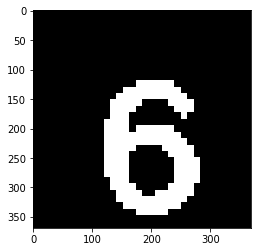

In [6]:
!curl https://images.homedepot-static.com/productImages/c0e71156-4516-439b-b99a-28b0f02050a1/svn/architectural-mailboxes-house-letters-numbers-3582b-4-64_1000.jpg -o number.jpg

import skimage.color
import skimage.io

image_gray = skimage.color.rgb2gray(skimage.io.imread('../4.png'))

plt.imshow(image_gray, cmap='gray')


In [7]:
image = resize(image_gray, (28, 28), anti_aliasing=True)
transformer_eval(image)

tensor([[[-0.1541, -0.1541, -0.1541, -0.1541, -0.1541, -0.1541, -0.1541,
          -0.1541, -0.1541, -0.1541, -0.1541, -0.1541, -0.1541, -0.1541,
          -0.1541, -0.1541, -0.1541, -0.1541, -0.1541, -0.1541, -0.1541,
          -0.1541, -0.1541, -0.1541, -0.1541, -0.1541, -0.1541, -0.1541],
         [-0.1541, -0.1541, -0.1541, -0.1541, -0.1541, -0.1541, -0.1541,
          -0.1541, -0.1541, -0.1541, -0.1541, -0.1541, -0.1541, -0.1541,
          -0.1541, -0.1541, -0.1541, -0.1541, -0.1541, -0.1541, -0.1541,
          -0.1541, -0.1541, -0.1541, -0.1541, -0.1541, -0.1541, -0.1541],
         [-0.1541, -0.1541, -0.1541, -0.1541, -0.1541, -0.1541, -0.1541,
          -0.1541, -0.1541, -0.1541, -0.1541, -0.1541, -0.1541, -0.1541,
          -0.1541, -0.1541, -0.1541, -0.1541, -0.1541, -0.1541, -0.1541,
          -0.1541, -0.1541, -0.1541, -0.1541, -0.1541, -0.1541, -0.1541],
         [-0.1541, -0.1541, -0.1541, -0.1541, -0.1541, -0.1541, -0.1541,
          -0.1541, -0.1541, -0.1541, -0.1541, -0

In [8]:
prediction = predict(image_gray, True)
prediction

# import time

# start_time = time.time()
# counter = 0
# for i in range(100):
#     prediction = predict(image_gray, True)
#     if prediction == 6:
#         counter = counter + 1

# total_time = time.time() - start_time
# print(total_time)

# counter

/media/richard/Save/SudokuSolver/env/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0

In [9]:
42.55736947059631

42.55736947059631